# Domain adaptation

In [1]:
from pathlib import Path
DATASET_ZIP_PATH = '/tmp/Adaptiope.zip'
DATASET_EXTRACTION_PATH = '/tmp/Adaptiope'
DATASET_PATH = Path('./data/adaptiope_small')

## Dataset extraction

In [2]:
from os import makedirs
from os.path import join, isdir
from shutil import copytree

In [3]:
!mkdir -p {DATASET_EXTRACTION_PATH}
!unzip -d {DATASET_EXTRACTION_PATH} {DATASET_ZIP_PATH}

unzip:  cannot find or open /tmp/Adaptiope.zip, /tmp/Adaptiope.zip.zip or /tmp/Adaptiope.zip.ZIP.


In [4]:
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
               "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
               "purse", "stand mixer", "stroller"]

if not isdir(DATASET_PATH):
    for d, td in zip([
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/product_images",
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/real_life"],[
        f"{DATASET_PATH}/product_images",
        f"{DATASET_PATH}/real_life"]):
        makedirs(td)
        for c in classes:
            c_path = join(d, c)
            c_target = join(td, c)
            copytree(c_path, c_target)

## Dataset exploration

In [5]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

/home/fbozzo/Documents/github/domain-adaptation/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset = ImageFolder(DATASET_PATH / "product_images")
idx_to_class = {v: k for k,v in dataset.class_to_idx.items()}

In [7]:
# imgs: List[str, int] path, class
seen_classes = set()
imgs = []
for i, (p, c) in enumerate(dataset.imgs):
    if c not in seen_classes:
        seen_classes.add(c)
        imgs.append(i)

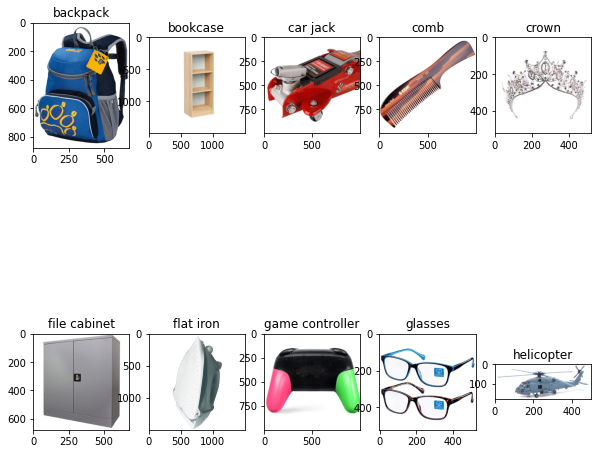

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(10,10))
for i in range(2):
    for j in range(5):
        image, title = dataset[imgs.pop(0)]
        axs[i,j].imshow(image)
        axs[i,j].set_title(idx_to_class[title])
plt.show()        

## Utility functions

In [5]:
import random
import numpy as np
import torch

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

def set_random_seed(seed=0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def print_epoch_chart(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    epoch,
    num_epochs
):
    clear_output(wait=True)
    
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(15,7))
    x = np.arange(len(train_losses))
    loss_ax.plot(x, train_losses, label='train')
    loss_ax.plot(x, val_losses, label='validation')
    loss_ax.set_title("Loss")
    loss_ax.set_ylim([0, 5])
    loss_ax.legend()
    acc_ax.plot(x, train_acc, label='train')
    acc_ax.plot(x, val_acc, label='validation')
    acc_ax.set_title("Accuracy")
    acc_ax.legend()
    fig.suptitle(f"Epoch {epoch+1} of {num_epochs}")
    plt.show()

/home/fbozzo/Documents/github/domain-adaptation/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Models

All models are composed by three main elements:

- backbone
- feature processor
- classifier

The backbone is a pretrained network from `torchvision` trained with a smaller learning rate than the one used for other two components.
The feature extractor is used for process the output of the backbone, we decided to separate these two steps into two classes in order to have more control on both of them, this allow to make tests with many combinations.
The last element is the classifier, it is a simple linear layer that takes the output of backbone (feature processor if it is used) and return an array of prediction with the same length of the number of classes.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

from typing import Optional

In [7]:
class Backbone(nn.Module):
    def __init__(
        self,
        backbone_type: str,
    ) -> None:
        super(Backbone, self).__init__()
        if backbone_type == "resnet34":
            self.backbone = models.resnet34(pretrained=True)
            self.output_num = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential()
        else:
            raise ValueError("select one valid backbone_type")
            
        
    def get_output_num(self):
        return self.output_num
        
    def forward(self, x):
        return self.backbone(x)
    
class FeatureProcessor(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super(FeatureProcessor, self).__init__()
        self.processing_layer = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU()
        )
        self.output_num = output_size
        
    def get_output_num(self):
        return self.output_num
        
    def forward(self, x):
        return self.processing_layer(x)
    
class Classifier(nn.Module):
    def __init__(
        self,
        backbone_type: str,
        n_classes: int,
        n_feature_extracted: Optional[int] = None
    ) -> None:
        super(Classifier, self).__init__()
        self.backbone = Backbone(backbone_type)
        if n_feature_extracted:
            self.processing_features = True
            self.processing_layer = FeatureProcessor(self.backbone.get_output_num(), n_feature_extracted)
        else:
            self.processing_features = False
        self.classification_layer = nn.Linear(
            self.processing_layer.get_output_num() if self.processing_features else self.backbone.get_output_num(),
            n_classes
        )
        self.output_num = n_classes
        
    def get_output_num(self):
        self.output_num
        
    def get_features(self, x):
        features = self.backbone(x)
        if self.processing_features:
            features = self.processing_layer(features)
        return features
        
    def forward(self, x):
        features = self.get_features(x)
        classes = self.classification_layer(features)
        
        return features, classes
    
class DomainAdaptationModel(nn.Module):
    def __init__(
        self,
        backbone_type: str,
        n_classes: int,
        n_feature_extracted: Optional[int] = None
    ) -> None:
        super(DomainAdaptationModel, self).__init__()
        self.backbone = Backbone(backbone_type)
        if n_feature_extracted:
            self.processing_features = True
            self.processing_layer = FeatureProcessor(self.backbone.get_output_num(), n_feature_extracted)
        else:
            self.processing_features = False
        self.batch_normalization_layers = {
            'source': nn.BatchNorm1d(self.processing_layer.get_output_num()),
            'target': nn.BatchNorm1d(self.processing_layer.get_output_num()),
        }
        self.classification_layer = nn.Linear(
            self.processing_layer.get_output_num() if self.processing_features else self.backbone.get_output_num(),
            n_classes
        )
        self.output_num = n_classes
        
    
    def get_output_num(self):
        self.output_num
        
    def get_features(self, x):
        features = self.backbone(x)
        if self.processing_features:
            features = self.processing_layer(features)
        return features
        
    def forward(self, x, dataset_name=None):
        features = self.get_features(x)
        #normalized = self.batch_normalization_layers[dataset_name](features)
        classes = self.classification_layer(features)
        
        # understand if we want to return normalized features instead of features
        return features, classes

## Baseline

### Dataset

In [8]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from torch.utils.data import DataLoader, random_split

In [9]:
source_dataset = ImageFolder(
    DATASET_PATH / "product_images",
    transform=T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)
target_dataset = ImageFolder(
    DATASET_PATH / "real_life",
    transform=T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

validation_ratio = .2
test_ratio = .2

validation_dataset, test_dataset, train_dataset = random_split(
    source_dataset,
    [
        int(len(source_dataset)*validation_ratio),
        int(len(source_dataset)*test_ratio),
        len(source_dataset) - (
            int(len(source_dataset)*validation_ratio)
            +int(len(source_dataset)*test_ratio)
        )
    ]
)

target_test_ratio = .4
target_test_dataset, target_train_dataset = random_split(
    target_dataset,
    [
        int(len(target_dataset)*target_test_ratio),
        len(target_dataset) - int(len(target_dataset)*target_test_ratio)
    ]
)

In [10]:
len(train_dataset), len(validation_dataset), len(test_dataset), len(target_train_dataset), len(target_test_dataset)

(1200, 400, 400, 1200, 800)

### Train

In [11]:
from torch.optim import lr_scheduler, SGD, Adam

from tqdm import tqdm

In [12]:
# misc
set_random_seed(33)
device = get_device()
num_threads = 4

# train
num_epochs = 5
batch_size = 32
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20

# domain adaptation loss
use_coral = True
coral_weight = 20

In [13]:
def get_data_loader(dataset, batch_size, num_threads):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_threads
    )

def get_optimizer(model, lr, wd, momentum):
    higher_lr_weights = []
    lower_lr_weights = []

    for name, param in model.named_parameters():
        if name.startswith('backbone'):
            lower_lr_weights.append(param)
        elif name.startswith('processing') or name.startswith('classification'):
            higher_lr_weights.append(param)
        else:
            raise ValueError(f"Unexpected type of weights {name}")

    optimizer = torch.optim.SGD(
        [
            {'params': lower_lr_weights},
            {'params': higher_lr_weights, 'lr': lr}
        ],
        lr=lr / 10,
        weight_decay=wd,
        momentum=momentum
    )

    return optimizer

In [14]:
model = Classifier(
    backbone_type="resnet34", 
    n_classes=len(dataset.classes),
    # n_feature_extracted=2048
)
model.to(device)
optimizer = get_optimizer(model, lr, weight_decay, momentum)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=scheduler_factor,
    patience=scheduler_patience,
    verbose=True
) 
dataloaders = {
    'train': {
        'source': get_data_loader(train_dataset, batch_size, num_threads),
        'target': get_data_loader(target_train_dataset, batch_size, num_threads),
    },
    'validation': {
        'source': get_data_loader(validation_dataset, batch_size, num_threads),
    }
    #'test': get_data_loader(test_dataset, batch_size, num_threads)
}
#summary(model, input_size=(batch_size, *dataset[0][0].size()))

NameError: name 'dataset' is not defined

In [ ]:
best_model = model
best_loss = np.Inf

phases_loss = {k: [] for k in dataloaders.keys()}
phases_acc = {k: [] for k in dataloaders.keys()}
for epoch in range(num_epochs):
    for phase, phase_dataloaders in dataloaders.items():
        source_dataloader = phase_dataloaders['source']
        target_dataloader = phase_dataloaders.get('target', None)
        if phase == "train":
            model.train()
        else:
            model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        for index, (x, labels) in enumerate(source_dataloader):
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.autocast(device_type=device.type):
                with torch.set_grad_enabled(phase == "train"):
                    features, predictions = model(x)
                    x = x.detach().cpu()
                    
                    loss = criterion(predictions, labels)
                    predictions = predictions.detach().cpu()
                    labels = labels.detach().cpu()
                    if use_coral and not target_dataloader is None:
                        source_feauteres = features.cpu()
                        target_x, _ = next(target_dataloader._get_iterator())
                        target_x = target_x.to(device)
                        target_fuatures, _ = model(target_x)
                        target_x = target_x.detach().cpu()
                        target_fuatures = target_fuatures.cpu()
                        loss = loss + coral_weight * coral(source_feauteres, target_fuatures)
                    epoch_loss += loss.item()
                    epoch_acc += (torch.argmax(predictions, 1) == labels).sum().item() / labels.size()[0]

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

        epoch_loss /= len(source_dataloader)
        epoch_acc /= len(source_dataloader)
        phases_loss[phase].append(epoch_loss)
        phases_acc[phase].append(epoch_acc)

        if phase == "validation" and abs(epoch_loss) <= abs(best_loss):
            best_model = model
            best_loss = epoch_loss
            scheduler.step(epoch_loss)
            
    print_epoch_chart(
        phases_loss['train'],
        phases_loss['validation'],
        phases_acc['train'],
        phases_acc['validation'],
        epoch,
        num_epochs
    )

### Test model

In [ ]:
features = []
predictions = []
reals = []
for x, y in test_dataset:
    x_gpu = x.unsqueeze(0).to(device)
    feature, predicted = best_model(x_gpu)
    features.append(feature.detach().cpu().numpy())
    predictions.append(np.argmax(predicted.detach().cpu().numpy()))
    reals.append(y)
    del x_gpu
features = np.array(features)
predictions = np.array(predictions)
reals = np.array(reals)

In [ ]:
def plot_predictions(index, idx_to_class, dataset, reals, predictions):
    x, _ = dataset[index]
    plt.imshow(x[1])
    print(idx_to_class[reals[index]], idx_to_class[predictions[index]])

In [ ]:
plot_predictions(350, idx_to_class, test_dataset, reals, predictions) 

In [ ]:
(reals == predictions).sum() / reals.shape[0]

### Plain

In [ ]:
features = []
predictions = []
reals = []
for x, y in target_dataset:
    x_gpu = x.unsqueeze(0).to(device)
    feature, predicted = best_model(x_gpu)
    features.append(feature.detach().cpu().numpy())
    predictions.append(np.argmax(predicted.detach().cpu().numpy()))
    reals.append(y)
    del x_gpu
features = np.array(features)
predictions = np.array(predictions)
reals = np.array(reals)

In [ ]:
def plot_predictions(index, idx_to_class, dataset, reals, predictions):
    x, _ = dataset[index]
    plt.imshow(x[1])
    print(idx_to_class[reals[index]], idx_to_class[predictions[index]])

In [ ]:
plot_predictions(350, idx_to_class, target_dataset, reals, predictions) 

In [ ]:
(reals == predictions).sum() / reals.shape[0]

In [ ]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.squeeze(features, 1))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=reals,
    s=5
)
plt.title('UMAP projection of features')

## CORAL loss

In [10]:
def coral(source_extracted_features, target_extracted_features, **kwargs):
    source = source_extracted_features.double()
    target = target_extracted_features.double()
    
    d = source.data.shape[1]
    ns, nt = source.data.shape[0], target.data.shape[0]
    # source covariance
    xm = torch.mean(source, 0, keepdim=True) - source
    xc = xm.t() @ xm / (ns - 1)

    # target covariance
    xmt = torch.mean(target, 0, keepdim=True) - target
    xct = xmt.t() @ xmt / (nt - 1)

    # frobenius norm between source and target
    loss = torch.mul((xc - xct), (xc - xct))
    loss = torch.sum(loss) / (4*d*d)
    return loss

## Contrastive adaptation with unsupervised

### Contrastive Domain Discrepancy

$\require{color}$
*Contrastive Domain Discrepancy (CDD)* is a measure used to quantify the dissimilarity between classes with respect to source and target domains. The computation is made on features extracted from linear layers of the network after the pretrained backbone module.

\begin{equation}
e_1 = \sum_{i=1}^{n_s}\sum_{j=1}^{n_s} \frac{\mu_{c_1c_1}(y_i^s, y_j^s)k(\phi(x_i^s), \phi(x_j^s))} { \sum_{i=1}^{n_s}\sum_{j=1}^{n_s}\mu_{c_1c_1}(y_i^s, y_j^s)}
\end{equation}

\begin{equation}
e_2 = \sum_{i=1}^{n_t}\sum_{j=1}^{n_t} \frac{\mu_{c_2c_2}(y_i^t, y_j^t)k(\phi(x_i^t), \phi(x_j^t))} {\sum_{i=1}^{n_t}\sum_{j=1}^{n_t}\mu_{c_2c_2}(y_i^t, y_j^t)}
\end{equation}

\begin{equation}
e_3 = \sum_{i=1}^{n_s}\sum_{j=1}^{n_t} \frac{\mu_{c_1c_2}(y_i^s, y_j^t)k(\phi(x_i^s), \phi(x_j^t))} {\sum_{i=1}^{n_s}\sum_{j=1}^{n_t}\mu_{c_1c_2}(y_i^s, y_j^t)}
\end{equation}

Suppose the two following tables contain the outputs of the last two linear layers of the network for the source dataset with a batch size equal to 5; the layer sizes are respectively 5 for the first and to 3 for the second: rows represent samples, and columns are the features.

$$
\begin{array}{|c|c|c|c|c|}
    \hline
    0.496257 & 0.768222 & 0.0884774 & 0.13203  & 0.307423 \\
    \hline
    0.634079 & 0.490093 & 0.896445  & 0.455628 & 0.632306 \\
    \hline
    0.348893 & 0.401717 & 0.0223258 & 0.168859 & 0.293888 \\
    \hline
    0.518522 & 0.697668 & 0.800011  & 0.161029 & 0.282269 \\
    \hline
    0.681609 & 0.915194 & 0.3971    & 0.874156 & 0.419408 \\
    \hline
\end{array}\quad\quad
\begin{array}{|c|c|c|c|c|}
    \hline
    0.552907 & 0.952738  & 0.0361648 \\
    \hline
    0.185231 & 0.373417  & 0.3051    \\
    \hline
    0.932    & 0.17591   & 0.269834  \\
    \hline
    0.15068  & 0.0317195 & 0.20813   \\
    \hline
    0.929799 & 0.723109  & 0.742336  \\
    \hline
\end{array}
$$

Same for the target dataset with a batch size equal to 4.

$$
\begin{array}{|c|c|c|c|c|}
    \hline
    0.526296 & 0.243658 & 0.584592 & 0.0331526 & 0.138717 \\
    \hline
    0.242235 & 0.815469 & 0.793161 & 0.278252  & 0.481959 \\
    \hline
    0.81978  & 0.997067 & 0.698441 & 0.567546  & 0.835243 \\
    \hline
    0.205599 & 0.593172 & 0.112347 & 0.153457  & 0.241708 \\
    \hline
\end{array}\quad\quad
\begin{array}{|c|c|c|c|c|}
\hline
0.726237 & 0.70108  & 0.203824 \\
\hline
0.651054 & 0.774486 & 0.436891 \\
\hline
0.519091 & 0.615852 & 0.810188 \\
\hline
0.980097 & 0.114688 & 0.316765 \\
\hline
\end{array}
$$

In these matrices, samples are ordered according to their respective class.

For each one of the two domains, it is also required a list describing the number of samples for each class: the *i*-th value of the list represents the number of samples for the class *i*.
In this case, we have $[2,2,1]$ for the source dataset and $[1, 1, 2]$ for the target dataset: note that both lists sum up respectively to 5 and 4, which are the sizes of the two minibatches.

#### Distance computation
The first step is to compute distances among:

- source/source dataset
- target/target dataset
- source/target dataset

All these three distances are computed for the output of each of the two linear layers, aggregating for the different number of features summing them (`compute_pairwise_distance` function).

Obtained result for distance source/target with shape equal to `[batch size source X batch size target]`:

$$
\begin{array}{cc}
Layer 1& Layer2 \\
\begin{array}{|c|c|c|c|c|}
\hline
 0.560438 & 0.615181 & 0.997362 & 0.120472  \\
 \hline
 0.591715 & 0.324145 & 0.384421 & 1.0529    \\
 \hline
 0.415092 & 0.82409  & 1.48532  & 0.0682521 \\
 \hline
 0.28955  & 0.143876 & 0.66175  & 0.583425  \\
 \hline
 1.29631  & 0.718872 & 0.383529 & 0.962352  \\
 \hline
\end{array}&
\begin{array}{|c|c|c|c|c|}
\hline
 0.121484 & 0.201988 & 0.713748 & 0.963555   \\
 \hline
 0.410307 & 0.395216 & 0.425351 & 0.698889   \\
 \hline
 0.3225   & 0.465132 & 0.656027 & 0.00826399 \\
 \hline
 0.779328 & 0.854408 & 0.839412 & 0.706618   \\
 \hline
 0.331919 & 0.173635 & 0.184789 & 0.553817   \\
\hline
\end{array}
\end{array}
$$

The output for source/source and target/target has respectively shape of `[batch size source X batch size source]` and `[batch size target X batch size target]`. Distances within the same dataset (source/source, target/target) require an extra step that iterates in the distance matrix over the diagonal, extracting square submatrices that contain all distances from samples belonging the same class. Obtained result for one layer of source/source distance (given distribution $[2,2,1]$):

$$
\begin{array}{ccc}
Class1&Class2&Class3  \\
\begin{array}{|c|c|}
\hline
 0        & 0.543124 \\
 \hline
 0.543124 & 0        \\
\hline
\end{array}&
\begin{array}{|c|c|}
\hline
 0       & 0.63506 \\
 \hline
 0.63506 & 0       \\
\hline
\end{array}&
\begin{array}{|c|c|}
\hline
 0 \\
\hline
\end{array}
\end{array}
$$

The distance matrix source/target is averaged over classes submatrices (colors are used to highlight class groups) creating a new mean matrix:

$$
\begin{array}{cc}
\text{Layer1 before the average}&\text{Layer1 after}\\
\begin{array}{|c|c|c|c|c|}
\hline
 \color{red}{0.560438} & \color{green}{0.615181} & \color{orange}{0.99736} & \color{orange}{0.120472}  \\
 \hline
 \color{red}{0.591715} & \color{green}{0.324145} & \color{orange}{0.384421} & \color{orange}{1.0529}    \\
 \hline
 \color{magenta}{0.415092 }& \color{brown}{0.82409  }& \color{olive}{1.48532  }& \color{olive}{0.0682521} \\
 \hline
 \color{magenta}{0.28955  }& \color{brown}{0.143876 }& \color{olive}{0.66175  }& \color{olive}{0.583425 } \\
 \hline
 \color{pink}{1.29631  }& \color{darkgrey}{0.718872 }& \color{teal}{0.383529 }& \color{teal}{0.962352 } \\
 \hline
\end{array}&
\begin{array}{|c|c|c|c|c|}
\hline
 \color{red}{0.511834} & \color{green}{0.476363} & \color{orange}{0.607436} & \color{orange}{0.607436} \\
 \hline
 \color{red}{0.511834} & \color{green}{0.476363} & \color{orange}{0.607436} & \color{orange}{0.607436} \\
 \hline
 \color{magenta}{0.432476 }& \color{brown}{0.397005 }& \color{olive}{0.567757 }& \color{olive}{0.567757 }\\
 \hline
 \color{magenta}{0.432476 }& \color{brown}{0.397005 }& \color{olive}{0.567757 }& \color{olive}{0.567757 }\\
 \hline
 \color{pink}{0.280219 }& \color{darkgrey}{0.307591 }& \color{teal}{0.655509 }& \color{teal}{0.655509 }\\
 \hline
\end{array}
\end{array}
$$

The computation of the mean subregions is also applied to source/source and target/target data.

#### Kernel computation
Distances and mean matrices are then used to compute a kernel for each layer, and the list of results are summed up. The final matrix has a shape of `[number of samples X number of samples]` and expresses the correlation between samples taken into consideration (in the following table source/target table is presented):

$$
\begin{array}{|c|c|c|}
\hline
 3.92554 & 3.90333 & 3.65386 \\
 \hline
 3.52906 & 3.25892 & 4.40912 \\
 \hline
 0.74786 & 2.26064 & 4.51405 \\
 \hline
\end{array}
$$

#### Maximum Mean Discrepancy (MMD) computation
The three kernels extracted from source/source, targe/target and source/target are composed together to obtaind the MMD:

MMD formulas
\begin{align}
\hat{\mathcal{D}}^{mmd}_{l} &= \frac{1}{n_s^2}\sum_{i=1}^{n_s}\sum_{j=1}^{n_s}k_l(\phi_l(x_i^s), \phi_l(x_j^s)) \\
& + \frac{1}{n_t^2}\sum_{i=1}^{n_t}\sum_{j=1}^{n_t}k_l(\phi_l(x_i^t), \phi_l(x_j^t)) \\
& - \frac{1}{n_s n_t}\sum_{i=1}^{n_t}\sum_{j=1}^{n_t}k_l(\phi_l(x_i^s), \phi_l(x_j^t))
\end{align}

The result is:

$$
\begin{array}{|c|c|c|}
\hline
  8.30697 &  8.33474 & 4.42708 \\
  \hline
  9.13727 &  9.64986 & 3.07151 \\
  \hline
 18.5041  & 15.4785  & 7.26769 \\
 \hline
\end{array}
$$

where the diagonal represents the intra class discrepancy and the rest of the matrix the inter class discrepancy.

$$
\begin{array}{cc}
\text{Intra class elements}&\text{inter class elements}\\
\begin{array}{|c|c|c|}
\hline
  8.30697 &  \color{lightgrey}{8.33474} & \color{lightgrey}{4.42708} \\
  \hline
  \color{lightgrey}{9.13727} &  9.64986 & \color{lightgrey}{3.07151} \\
  \hline
  \color{lightgrey}{18.5041}  & \color{lightgrey}{15.4785}  & 7.26769 \\
 \hline
\end{array}&
\begin{array}{|c|c|c|}
\hline
  \color{lightgrey}{8.30697} &  8.33474 & 4.42708 \\
  \hline
  9.13727 &  \color{lightgrey}{9.64986} & 3.07151 \\
  \hline
 18.5041  & 15.4785  & \color{lightgrey}{7.26769} \\
 \hline
\end{array}
\end{array}
$$

#### CDD, intra class, infra class computation
The intra and inter class measures can be computed averaging over vectors of the previous step. The CDD instead can be obtained applying the following formula:

\begin{align}
\hat{\mathcal{D}}^{cdd}_{l} &= \underbrace{\frac{1}{M}\sum_{c=1}^M\hat{\mathcal{D}}^{cc}(\hat{y}_{1:n_t}^t, \phi)}_\text{intra class} \\
&- \underbrace{\frac{1}{M(M -1)} \sum_{c=1}^M\sum_{c'=1\\c'\ne c}^M\hat{\mathcal{D}}^{cc'}(\hat{y}_{1:n_t}^t, \phi)}_\text{inter class}
\end{align}


In [15]:
from typing import Tuple, List, Dict, Optional

class ConstrativeDomainDiscrepancy:
    def __init__(
        self,
        num_layers: int,
        kernel_orders: Tuple[int],
        kernel_multipliers: Tuple[int],
        num_classes: int,
        device: torch.device
    ):
        self.num_layers = num_layers
        self.kernel_orders = kernel_orders
        self.kernel_multipliers = kernel_multipliers
        self.num_classes = num_classes
        self.device = device
        
        assert num_layers == len(kernel_orders) == len(kernel_multipliers), "There must be one kernel order and multiplier for each layer"
    
    def activate(
        self,
        source_layers_out: List[torch.Tensor], # shape: [num_layers X batch_size_source X output_of_layer(i)]
        target_layers_out: List[torch.Tensor], # shape: [num_layers X batch_size_target X output_of_layer(i)]
        samples_for_class_source: List[int], # shape: [num_classes]
        samples_for_class_target: List[int], # shape: [num_classes] 
    ) -> Dict[str, float]:
        assert len(source_layers_out) == len(target_layers_out) == self.num_layers, "number of layers must be the same"

        layers_dist = []
        layers_mean = []
        for src, trg in zip(source_layers_out, target_layers_out):
            layer_distances, layer_mean_distances = self.activate_layer(
                src,
                trg,
                samples_for_class_source,
                samples_for_class_target
            )
            layers_dist.append(layer_distances)
            layers_mean.append(layer_mean_distances)
            
        for i in range(self.num_layers):
            for c in range(len(samples_for_class_source)):
                # shape goes from [num_classes] to [num_classes X 1 X 1]
                layers_mean[i]['ss'][c] = layers_mean[i]['ss'][c].view(
                    len(samples_for_class_source), 1, 1
                )
                layers_mean[i]['tt'][c] = layers_mean[i]['tt'][c].view(
                    len(samples_for_class_source), 1, 1
                )
        
        class_kernel_dist = self.classes_mean_kernel(
            samples_for_class_source,
            samples_for_class_target,
            self.compute_cum_kernel_dist(
                [i['st'] for i in layers_dist],
                [i['st'] for i in layers_mean]
            )
        )
        
        cum_kernel_dist_ss = []
        cum_kernel_dist_tt = []
        for class_index in range(len(samples_for_class_source)):
            cum_kernel_dist_ss.append(
                torch.mean(
                    self.compute_cum_kernel_dist(
                        [i['ss'] for i in layers_dist],
                        [i['ss'] for i in layers_mean],
                        class_index
                    ).view(len(samples_for_class_source), -1), dim=1
                )
            )
            cum_kernel_dist_tt.append(
                torch.mean(
                    self.compute_cum_kernel_dist(
                        [i['tt'] for i in layers_dist],
                        [i['tt'] for i in layers_mean],
                        class_index
                    ).view(len(samples_for_class_source), -1), dim=1
                )
            )
        kernel_dist_ss = torch.stack(cum_kernel_dist_ss, dim=0)
        # understand why transpose here
        kernel_dist_tt = torch.stack(cum_kernel_dist_tt, dim=0).transpose(1, 0)
        
        mmds = kernel_dist_ss + kernel_dist_tt - 2 * class_kernel_dist
        
        intra_mmds = torch.diag(mmds, 0)
        intra = torch.sum(intra_mmds) / self.num_classes
        
        inter = None
        # trick to create a mask to exclude diagonal like
        # False True True
        # True False True
        # True True False
        inter_mask = (torch.ones([len(samples_for_class_source), len(samples_for_class_source)]).to(self.device) - \
            torch.eye(len(samples_for_class_source))).type(torch.bool)
        inter_mmds = torch.masked_select(mmds, inter_mask)
        # inter is a flatten of all cells except the diagonal
        inter = torch.sum(inter_mmds) / (self.num_classes * (self.num_classes - 1))
        
        cdd = intra - inter
        return {
            'ccd': cdd,
            'intra': intra,
            'inter': inter
        }

        
    def activate_layer(
        self,
        source_features: torch.Tensor, # shape: [batch_size_source X output_of_layer(i)]
        target_features: torch.Tensor, # shape: [batch_size_target X output_of_layer(i)]
        samples_for_class_source: List[int], # shape: [num_classes]
        samples_for_class_target: List[int], # shape: [num_classes] 
    ):
        assert len(samples_for_class_source) == len(samples_for_class_target), "number of classes must be the same"
        
        num_classes = len(samples_for_class_source)
        
        # ss means source, source
        # tt means target, target
        # st means source, target
        distances = {}
        
        distances['ss'] = self.compute_pairwise_distance(source_features, source_features)
        distances['tt'] = self.compute_pairwise_distance(target_features, target_features)
        distances['st'] = self.compute_pairwise_distance(source_features, target_features)
        distances['ss'] = self.extract_classwise_information(
            distances['ss'],
            samples_for_class_source
        )
        distances['tt'] = self.extract_classwise_information(
            distances['tt'],
            samples_for_class_target
        )
        
        mean_distances = self.pairwise_class_mean_distance(
            samples_for_class_source,
            samples_for_class_target,
            distances
        )
        
        return distances, mean_distances
        
    def compute_pairwise_distance(
        self,
        ten1: torch.Tensor, # shape [batch_size_1 x features_length]
        ten2: torch.Tensor # shape [batch_size_2 x features_length]
    ) -> torch.Tensor: # shape [batch_size_1 x batch_size_2 x features_length]
        # batch_size 1 and 2 could be different
        assert ten1.shape[1] == ten2.shape[1], "Features length must be the same"
        batch_size_1 = ten1.shape[0]
        batch_size_2 = ten2.shape[0]
        
        features_length = ten1.shape[1]
        
        # goes from [batch_size_1 x features_length] to [batch_size_1 x batch_size_2 x features_length]
        expanded_1 = ten1.unsqueeze(1).expand(batch_size_1, batch_size_2, features_length)
        expanded_2 = ten2.unsqueeze(0).expand(batch_size_1, batch_size_2, features_length)
        
        # sum over the dimension 2 collases features
        # goes from [batch_size_1 x batch_size_2 x features_length] to [batch_size_1 x batch_size_2]
        squared_distance = ((expanded_1 - expanded_2)**2).sum(2)
        return squared_distance
    
    def extract_classwise_information(
        self,
        distance: torch.Tensor, # shape: [batch_size x batch_size]
        samples_for_class: List[int], # shape: [num_classes]
    ) -> List[torch.Tensor]:
        # the idea is to create one square submatrix for each class with side
        # equal to the amount of samples for that class inside the batch. In this way the
        # size of matrices will be proportional to the impact of it inside the batch_size
        square_submatrices_length = [length for length in samples_for_class]
        
        classes_distance = []
        x_offset = 0
        y_offset = 0
        for length in square_submatrices_length:
            class_distance = distance[x_offset:x_offset+length, y_offset:y_offset+length]
            classes_distance.append(class_distance)
            # translation over the diagonal of the matrix
            x_offset += length
            y_offset += length
        return classes_distance
    
    def pairwise_class_mean_distance(
        self,
        samples_for_class_source: List[int], # shape: [num_classes] 
        samples_for_class_target: List[int], # shape: [num_classes] 
        distances: Dict[str, torch.Tensor] # shape [batch_size_1 x batch_size_2 x features_length]
    ) -> Dict[str, torch.Tensor]:
        # patches will contain the square submatrices computed in extract_classwise_information
        patches = {}
        mean_distances = {}
        mean_distances['st'] = torch.zeros_like(distances['st'], requires_grad=False).to(self.device)
        mean_distances['ss'] = []
        mean_distances['tt'] = []
        for c in range(len(samples_for_class_source)):
            mean_distances['ss'] += [
                torch.zeros(
                    len(samples_for_class_source), requires_grad=False
                ).to(self.device)
            ]
            mean_distances['tt'] += [
                torch.zeros(
                    len(samples_for_class_source), requires_grad=False
                ).to(self.device)
            ]
        
        classes_distance = []
        source_start = 0
        source_end = 0
        for source_class_index in range(len(samples_for_class_source)):
            source_stard = source_end
            source_end = source_stard + samples_for_class_source[source_class_index]
            patches['ss'] = distances['ss'][source_class_index]
            
            target_start = 0
            target_end = 0
            for target_class_index in range(len(samples_for_class_target)):
                target_start = target_end
                target_end = target_start + samples_for_class_target[target_class_index]
                patches['tt'] = distances['tt'][target_class_index]
                
                patches['st'] = distances['st'][
                    source_start:source_start + samples_for_class_source[source_class_index],
                    target_start:target_start + samples_for_class_target[target_class_index]
                ]
                
                mean = self.mean_estimation(patches)
                
                mean_distances['ss'][source_class_index][target_class_index] = mean
                mean_distances['tt'][source_class_index][target_class_index] = mean
                mean_distances['st'][source_stard:source_end, target_start:target_end] = mean

        return mean_distances
    
    def mean_estimation(
        self,
        distances_patches: Dict[str, torch.Tensor]
    ) -> torch.Tensor:
        patches_sum = torch.sum(distances_patches['ss']) + \
            torch.sum(distances_patches['tt']) + \
            torch.sum(distances_patches['st'])
        
        batch_size_source = distances_patches['ss'].shape[0]
        batch_size_target = distances_patches['tt'].shape[0]
        
        # batch_size_source and batch_size_taret are removed in order
        # to obtain an unbiased estimator since total_amount_values
        # will be used as denominator for the mean computation
        total_amount_values = (batch_size_source * batch_size_source) + \
            (batch_size_target * batch_size_target) + \
            2 * (batch_size_source * batch_size_target) - \
            batch_size_source - batch_size_target
        
        mean = patches_sum.item() / total_amount_values
        return mean
    
    def compute_cum_kernel_dist(
        self,
        layer_dist_st: List[torch.Tensor], # shape: [batch_size_source X batch_size_target]
        layer_mean_st: List[torch.Tensor], # shape: [batch_size_source X batch_size_target]
        class_index: Optional[int]=None
    ):
        cum_kernel_dist = None
        for i, order, multiplier in zip(
            range(self.num_layers),
            self.kernel_orders,
            self.kernel_multipliers
        ):
            distance = layer_dist_st[i] if class_index is None else layer_dist_st[i][class_index]
            mean = layer_mean_st[i] if class_index is None else layer_mean_st[i][class_index]
            
            kernel_dist = self.compute_kernel_dist(distance, mean, order, multiplier)
            if cum_kernel_dist is None:
                cum_kernel_dist = kernel_dist
            else:
                cum_kernel_dist += kernel_dist
                
        return cum_kernel_dist
    
    # using the same kernel function from the original source code
    # https://github.com/kgl-prml/Contrastive-Adaptation-Network-for-Unsupervised-Domain-Adaptation/blob/39acc516231a35206eb6277e527ee08acfdd07a6/discrepancy/cdd.py#L73
    def compute_kernel_dist(
        self,
        distance: torch.Tensor, # shape: [batch_size_source X batch_size_target]
        mean: torch.Tensor, # shape: [batch_size_source X batch_size_target]
        kernel_order: int,
        kernel_multiplier: int
    ):
        base_mean = mean / (kernel_multiplier ** (kernel_order // 2))
        mean_list = [base_mean * (kernel_multiplier**i) for i in range(kernel_order)]
        mean_tensor = torch.stack(mean_list, dim=0).to(self.device)

        eps = 1e-5
        mean_mask = (mean_tensor < eps).type(torch.FloatTensor)
        mean_tensor = (1.0 - mean_mask) * mean_tensor + mean_mask * eps 
        mean_tensor = mean_tensor.detach()

        for i in range(len(mean_tensor.size()) - len(distance.size())):
            distance = distance.unsqueeze(0)

        distance = distance / mean_tensor
        upper_mask = (distance > 1e5).type(torch.FloatTensor).detach()
        lower_mask = (distance < 1e-5).type(torch.FloatTensor).detach()
        normal_mask = 1.0 - upper_mask - lower_mask
        distance = normal_mask * distance + upper_mask * 1e5 + lower_mask * 1e-5
        kernel_val = torch.sum(torch.exp(-1.0 * distance), dim=0)
        return kernel_val
    
    def classes_mean_kernel(
        self,
        samples_for_class_source: List[int], # shape: [num_classes] 
        samples_for_class_target: List[int], # shape: [num_classes] 
        cumulate_kernel: torch.Tensor # shape: [batch_size_source X batch_size_target]
    ) -> torch.Tensor: # shape: [num_classes X num_classes]
        mean = torch.zeros(
            (len(samples_for_class_source), len(samples_for_class_source))
        ).to(self.device)
        x_start = 0
        x_end = 0
        for source_class_index in range(len(samples_for_class_source)):
            x_start = x_end
            x_end = x_start + samples_for_class_source[source_class_index]
            
            y_start = 0
            y_end = 0
            for target_class_index in range(len(samples_for_class_target)):
                y_start = y_end
                y_end = y_start + samples_for_class_target[target_class_index]
                
                class_mean = torch.mean(
                    cumulate_kernel[
                        x_start:x_start + samples_for_class_source[source_class_index],
                        y_start:y_start + samples_for_class_target[target_class_index]
                    ]
                )
                mean[source_class_index, target_class_index] = class_mean
        return mean

### Clustering

To be able to compute the Contrastive Domain Discrepancy (CCD), it is necessary to know the ground truth for both the source and target domains: for this reason, a clustering technique is needed to estimate target labels using the features extracted by the network on the target dataset. The paper proposes spherical kmeans for this task, which uses the *cosine distance* metric:

\begin{equation}
dist(a, b) = \frac{1}{2}\left(1 - \frac{\langle a, b \rangle}{\|a\| \|b\|}\right)
\end{equation}

Additionally, as reported in the paper, the number of cluster should be the number of classes in the source domain (which in this case is the same with respect to the target domain). Target centers should be initialized as the centers of the source domain.

During the iterative step of the spherical kmeans algorithm, the update of the target center of class *c* is performed as:

\begin{equation}
O^{tc} = \sum_{i=1}^{N_t}\textbf{1}_{\hat{y}_i^t=c} \frac{\phi_l (x_i^t)}{\| \phi_l (x_i^t)\|}
\end{equation}

according to

\begin{equation}
\textbf{1}_{\hat{y}_i^t=c} = 
    \begin{cases}
      1 & \textrm{if } \hat{y}_i^t=c \\
      0 & \textrm{otherwise}
    \end{cases}
\end{equation}

The iterative procedure is stopped when the mean distance of the centers computed by two adjacent iterations is below a certain threshold.

An additional step is performed to avoid ambiguous label assignments:
- each sample should have a distance to its assigned cluster below a certain threshold;
- each cluster should have assigned at least a certain amount of samples.

While in a first moment many classes could not be included, as the training proceeds the situation improves, since:
- the accuracy of the model increases;
- thanks to CCD, the intraclass domain discrepancy decreases and the interclass domain discrepancy increases.

In [25]:
from torch.nn.functional import normalize, one_hot

class Clustering:
    def __init__(
        self,
        batch_size: int,
        num_classes: int,
        stop_threshold: float,
        device: torch.device
    ):
        self.stop_threshold = stop_threshold
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.centers = None
        self.device = device
    
    def set_init_centers(
        self,
        features: torch.tensor, # shape: [num_samples X num_features]
        labels: torch.tensor # shape: [num_samples]
    ):
        self.init_centers = self.compute_centers(features, labels)
        self.centers = self.init_centers
        
    def compute_centers(
        self,
        features: torch.tensor, # shape: [num_samples X num_features]
        labels: torch.tensor # shape: [num_samples]
    ):
        centers = torch.zeros((self.num_classes, features.size(1))).to(self.device)
        for class_id in range(self.num_classes):
            class_sample_positions = (labels == class_id)
            centers[class_id] = torch.sum(features[class_sample_positions], dim=0)
        return centers
        
    def forward(
        self,
        features: torch.tensor, # shape: [num_samples X num_features]
    ) -> torch.tensor: # shape: [num_samples] TODO update docs
        assert self.init_centers is not None, "initialize the centers of clusters"
        while True:
            centers = torch.zeros((self.num_classes, features.size(1))).to(self.device)
            class_counts = torch.zeros(self.num_classes).to(self.device)
            for start in range(0, features.size(0), self.batch_size):
                end = min(start + self.batch_size, features.size(0))
                batch = features[start:end]
                _, labels = self.classify_samples(batch)
                # labels_onehot shape: [batch_size X num_classes]
                labels_onehot = one_hot(labels, self.num_classes)

                class_counts += torch.sum(labels_onehot, dim=0)
                centers += self.compute_centers(batch, labels)

            # checks if one class has not any sample, in this way no update on those clusters
            mask = (class_counts.unsqueeze(1) > 0).float().to(self.device)
            centers = mask * centers + (1 - mask) * self.init_centers
            if self.check_stop_criterion(centers):
                break
            self.centers = centers
        self.centers = centers
        
        # TODO: see if the alignment is a fundamental part
        
        distances, labels = self.classify_samples(features)
        return distances, labels
        
        
    def classify_samples(
        self,
        features: torch.tensor # shape: [batch size X num_features]
    )-> Tuple[torch.tensor, torch.tensor]:
        distances = self.compute_cosine_distance(
            features,
            self.centers,
            cross=True
        )
        distances, labels = torch.min(distances, dim=1)

        return distances, labels
    
    def compute_cosine_distance(
        self,
        tensor_1: torch.tensor,
        tensor_2: torch.tensor,
        cross: bool
    ) -> torch.tensor:
        tensor_1 = normalize(tensor_1, dim=1)
        tensor_2 = normalize(tensor_2, dim=1)
        if not cross:
            return 0.5 * (1.0 - torch.sum(tensor_1 * tensor_2, dim=1))
        else:
            assert(tensor_1.size(1) == tensor_2.size(1))
            return 0.5 * (1.0 - torch.matmul(tensor_1, tensor_2.transpose(0, 1)))

    def check_stop_criterion(self, centers):
        distances = self.compute_cosine_distance(centers, self.centers, cross=False)
        distances = torch.mean(distances, dim=0)
        print('Clustering distance %.8f' % distances.item())
        return distances.item() < self.stop_threshold

### Dataset & Dataloader

In [111]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from torch.utils.data import DataLoader, random_split, Dataset

class SingleDataSourceDataset(Dataset):
    def __init__(
        self,
        dataset_path: str,
        name: str, 
    ):
        self.inner_dataset = ImageFolder(
            dataset_path,
            transform=T.Compose([
                T.Resize((256, 256)),
                T.CenterCrop((224, 224)),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )
        if name not in ["source", "target"]:
            raise ValueError("name must be source or target")
        self.name = name
        self.class_to_idx = self.inner_dataset.class_to_idx
        self.class_indexes = np.array([class_id for _, class_id in self.inner_dataset.samples])
        self.num_classes = len(self.inner_dataset.classes)
        
    def get_name(self):
        return self.name

    def __len__(self):
        return len(self.inner_dataset)

    def __getitem__(self, idx):
        return self.inner_dataset[idx]
         
class CANDataset(Dataset):
    def __init__(
        self,
        source_dataset_path: str,
        target_dataset_path: str,
        samples_per_class: int,
        classes_per_batch: int,
        filter_mask: np.ndarray,
        target_clustering_labels: np.ndarray,
    ):
        self.source_dataset = SingleDataSourceDataset(source_dataset_path, "source")
        self.target_dataset = SingleDataSourceDataset(target_dataset_path, "target")
        assert len(self.source_dataset) == len(self.target_dataset), "Number of classes must be the same for source and target dataset"
        
        self.num_classes = self.source_dataset.num_classes
        self.samples_per_class = samples_per_class
        self.classes_per_batch = classes_per_batch
        self.target_clustering_labels = target_clustering_labels
        
        self.source_class_indexes = [
            np.argwhere(
                self.source_dataset.class_indexes == idx
            ).squeeze() for idx in range(self.num_classes)
        ]
        self.target_class_indexes = [
            np.argwhere(
                self.target_dataset.class_indexes == idx
            ).squeeze() for idx in range(self.num_classes)
        ] 
        valid_indexes = np.argwhere(filter_mask == True).flatten()
        for idx in range(self.num_classes):
            self.target_class_indexes[idx] = self.target_class_indexes[idx][
                np.isin(self.target_class_indexes[idx], valid_indexes)
            ]
        
    def __len__(self):
        return self.num_classes
    
    def __getitem__(self, idx):
        source_idxs = np.random.choice(
            self.source_class_indexes[idx],
            size=self.samples_per_class, 
            replace=True
        )
        target_idxs = np.random.choice(
            self.target_class_indexes[idx],            
            size=self.samples_per_class, 
            replace=True
        )
        source_samples = [self.source_dataset[i] for i in source_idxs]
        source_xs = torch.tensor([sample[0].numpy() for sample in source_samples])
        source_ys = torch.tensor([sample[1] for sample in source_samples])
        target_xs = torch.tensor([self.target_dataset[i][0].numpy() for i in target_idxs])
        target_ys = torch.tensor(self.target_clustering_labels[target_idxs])
        
        return {
            'source_xs': source_xs,
            'source_ys': source_ys,
            'target_xs': target_xs,
            'target_ys_clustering': target_ys,
        }
    
def CAN_collate_function(data):
    # if return data the shape will be:
    # list of 4 array of 2 element (x,y) of 8 elements
    return {
        'source_xs': torch.cat([c['source_xs'] for c in data]),
        'source_ys': torch.cat([c['source_ys'] for c in data]),
        'target_xs': torch.cat([c['target_xs'] for c in data]),
        'target_ys_clustering': torch.cat([c['target_ys_clustering'] for c in data]),
    }

### Train phase

In [112]:
# misc
set_random_seed(33)
device = get_device()
num_threads = 4
num_features = 2048
source_path = DATASET_PATH / "product_images"
target_path = DATASET_PATH / "real_life"

# clustering
batch_size_clustering = 1000
stop_threshold_clustering = 0.0005
num_epochs = 30
threshold_clustering = 1.0
min_samples_per_class_clustering = 3
skipped_clustering_epochs = 5

# ccd
num_layers = 1
kernel_orders = (5,)
kernel_multipliers = (2,)

# train
num_epochs = 5
batch_size = 32
classes_per_batch = 4
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20

In [113]:
source_dataset = SingleDataSourceDataset(source_path, "source")
target_dataset = SingleDataSourceDataset(target_path, "target")

dataloaders = {
    'source_net': DataLoader(
        source_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False
    ),
}

clustering_datasets = {
    'source': SingleDataSourceDataset(source_path, "source"),
    'target': SingleDataSourceDataset(target_path, "target"),
}

In [114]:
from torch.optim import lr_scheduler, SGD, Adam

cdd = ConstrativeDomainDiscrepancy(
    num_layers,
    kernel_orders,
    kernel_multipliers,
    len(classes),
    device,
)

clustering = Clustering(
    batch_size_clustering,
    len(classes),
    stop_threshold_clustering,
    device,
)
model = DomainAdaptationModel(
    backbone_type="resnet34", 
    n_classes=len(classes),
    n_feature_extracted=num_features
)
model.to(device)
optimizer = get_optimizer(model, lr, weight_decay, momentum)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=scheduler_factor,
    patience=scheduler_patience,
    verbose=True
)

In [120]:
from typing import Dict

def clustering_initialization(
    model: torch.nn.Module,
    clustering: Clustering,
    clustering_datasets: Dict[str, Dataset],
):
    with torch.no_grad():
        source_features = []
        source_labels = []
        dataset = clustering_datasets['source']
        for image, label in dataset:
            # name used internally to decide which batch normalization
            # layer to use
            image = image.to(clustering.device).unsqueeze(0)
            features, _ = model(image, dataset.get_name())
            source_features.append(features)
            source_labels.append(label)

        source_features = torch.cat(source_features)
        source_labels = torch.tensor(source_labels)
        
        clustering.set_init_centers(source_features, source_labels)
        
def clustering_inference(
    model: torch.nn.Module,
    clustering: Clustering,
    clustering_datasets: Dict[str, Dataset],
    dataset_source: str,
):
    with torch.no_grad():
        features = []
        dataset = clustering_datasets[dataset_source]
        for image, _ in dataset:
            # name used internally to decide which batch normalization
            # layer to use
            image = image.to(clustering.device).unsqueeze(0)
            fs, _ = model(image, dataset.get_name())
            features.append(fs)
        features = torch.cat(features)

        return clustering.forward(features)
        
def filtering(
    threshold: int,
    min_samples_per_class: int,
    predicted_labels: torch.tensor, # shape: [num_samples]
    clustering_distances: torch.tensor, # shape: [num_samples]
):
    clusters_to_delete = torch.argwhere(torch.bincount(predicted_labels.int()) < min_samples_per_class)
    
    filter_mask = torch.zeros(predicted_labels.shape, dtype=torch.bool)

    for i, (label, dist) in enumerate(zip(predicted_labels, clustering_distances)):
        if dist < threshold and label not in clusters_to_delete:
            filter_mask[i] = True

    return filter_mask, clusters_to_delete


# start training loop
for epoch in range(num_epochs):
    if epoch % skipped_clustering_epochs == 0:
        model.eval()
        clustering_initialization(model, clustering, clustering_datasets)
        target_clustering_distances, target_clustering_labels = clustering_inference(
            model,
            clustering,
            clustering_datasets,
            "target",
        )
        filter_mask, clusters_to_delete = filtering(
            threshold_clustering,
            min_samples_per_class_clustering,
            target_clustering_labels,
            target_clustering_distances,
        )
        can_loader = DataLoader(
            CANDataset(
                source_path,
                target_path,
                batch_size // classes_per_batch,
                classes_per_batch,
                filter_mask.numpy(),
                target_clustering_labels,
            ),
            batch_size=classes_per_batch,
            shuffle=True,
            drop_last=False,
            collate_fn=CAN_collate_function
        )
        can_loader_iterator = iter(can_loader)
    
    model.train()
    epoch_ce_loss = 0.0
    epoch_cdd_loss = 0.0
    epoch_acc = 0.0
    with torch.set_grad_enabled(True):
        for source_x, source_labels in dataloaders['source_net']:
            source_x = source_x.to(device)
            source_labels = source_labels.to(device)
            optimizer.zero_grad()

            features, predictions = model(source_x)
            source_x = source_x.detach().cpu()

            ce_loss = criterion(predictions, source_labels)
            predictions = predictions.detach().cpu()
            source_labels = source_labels.detach().cpu()

            epoch_ce_loss += ce_loss.item()
            epoch_acc += (torch.argmax(predictions, 1) == source_labels).sum().item() / source_labels.size()[0]

            ce_loss.backward()
            optimizer.step()

            if (len(classes) - len(clusters_to_delete)) >= classes_per_batch:
                try:
                    can_sample = next(can_loader_iterator)
                except Exception:
                    can_loader_iterator = iter(can_loader)
                    can_sample = next(can_loader_iterator)

                source_xs = can_sample['source_xs'].to(device)
                source_ys = can_sample['source_ys'].to(device)
                target_xs = can_sample['target_xs'].to(device)
                target_ys = can_sample['target_ys_clustering'].to(device)

                feature_source, prediction_source = model(source_xs)
                prediction_source = torch.argmax(prediction_source, 1)
                feature_target, _ = model(target_xs)

                cdd_loss = cdd.activate(
                    [feature_source],
                    [feature_target],
                    list(torch.bincount(prediction_source.int(), minlength=len(classes)).detach().cpu().numpy()),
                    list(torch.bincount(target_ys.int(), minlength=len(classes)).detach().cpu().numpy()),
                )

                cdd_loss *= 1
                cdd_loss.backward()
                epoch_cdd_loss += cdd_loss.item()
                print(f"{epoch_cdd_loss=}")

        epoch_ce_loss /= len(dataloaders['source_net'])
        epoch_acc /= len(dataloaders['source_net'])
        
        print(f"{epoch_ce_loss=} {epoch_acc=}")   

Clustering distance 0.01806818
Clustering distance 0.00037571


/tmp/ipykernel_31530/1297127739.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ys = torch.tensor(self.target_clustering_labels[target_idxs])


ZeroDivisionError: float division by zero

In [ ]:
for x, y in dataloaders['source_net']:
    print(x.shape, y.shape)
    break

In [122]:
prediction_source
source_ys

tensor([12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0, 13, 13,
        13, 13, 13, 13, 13, 13, 16, 16, 16, 16, 16, 16, 16, 16],
       device='cuda:0')

In [123]:
prediction_source


tensor([ 4,  1, 10,  1,  9,  9,  8,  4, 17,  4,  8,  8,  8, 17, 15,  8, 17,  9,
         0,  4, 10,  4, 17,  9, 10, 11, 10, 17, 10, 16, 10,  8],
       device='cuda:0')